In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

In [13]:
from torchvision.datasets import MNIST

In [14]:
#Get data


mnist_trainset = MNIST("MNIST/", train=True, download=False)
mnist_testset = MNIST("MNIST/", train=False, download=True)



#Reduce size of datasets for easier handling: 

train_size = 3000
valid_size = 1500
test_size = 1500


x_train = mnist_trainset.data[:train_size].reshape(train_size,1,28,28).float()
y_train = mnist_trainset.targets[:train_size]




x_valid = mnist_trainset.data[train_size:train_size+valid_size].reshape(valid_size,1,28,28).float()
y_valid = mnist_trainset.targets[train_size:train_size+valid_size]


x_test = mnist_testset.data[:test_size].reshape(test_size,1,28,28).float()
y_test = mnist_testset.targets[:test_size]


del mnist_trainset,mnist_testset


x_train.div_(255)
x_valid.div_(255)
x_test.div_(255)

print('yes')

yes


# Define Model

In [15]:
def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)


compute_conv_dim(26,2,0,1)

25

In [16]:
num_classes = 10
channels = x_train.shape[1]
conv_channels=32
hidden_features=100

def compute_conv_dim(dim_size,kernel_size,padding,stride):
    return int((dim_size - kernel_size + 2 * padding) / stride + 1)


class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=channels,
                                          out_channels = conv_channels,
                                          kernel_size=3,
                                          stride = 1)
        
        conv_dim_conv1 = compute_conv_dim(28,3,0,1)
        
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=1)
        
        conv_dim_pool1 = compute_conv_dim(conv_dim_conv1,2,0,1)
        
        self.l1_in_features = conv_channels*conv_dim_pool1**2
        
        self.line1 = nn.Linear(in_features=self.l1_in_features,
                              out_features= hidden_features,
                              bias=True)
        
        self.lineout = nn.Linear(in_features=hidden_features,
                              out_features= num_classes,
                              bias=True)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = x.view(-1,self.l1_in_features)
        x = nn.functional.relu(self.line1(x))
        x = nn.functional.softmax(self.lineout(x),dim=0)
        
        return x
    
model = Net()

In [17]:
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (line1): Linear(in_features=20000, out_features=100, bias=True)
  (lineout): Linear(in_features=100, out_features=10, bias=True)
)


# Training loop

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

/Users/Morten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  1 : Train Loss 0.076669 , Train acc 0.282667, Valid acc 0.257333
Epoch 11 : Train Loss 0.056390 , Train acc 0.822667, Valid acc 0.819333
Epoch 21 : Train Loss 0.053127 , Train acc 0.910333, Valid acc 0.893333
Epoch 31 : Train Loss 0.051682 , Train acc 0.929667, Valid acc 0.910667
Epoch 41 : Train Loss 0.051188 , Train acc 0.942667, Valid acc 0.917333
Epoch 51 : Train Loss 0.050891 , Train acc 0.947333, Valid acc 0.923333
Epoch 61 : Train Loss 0.050674 , Train acc 0.952000, Valid acc 0.924667
Epoch 71 : Train Loss 0.050489 , Train acc 0.956333, Valid acc 0.928000
Epoch 81 : Train Loss 0.050326 , Train acc 0.960333, Valid acc 0.930000
Epoch 91 : Train Loss 0.050171 , Train acc 0.964667, Valid acc 0.932000
Epoch 101 : Train Loss 0.050065 , Train acc 0.965667, Valid acc 0.930667
Epoch 111 : Train Loss 0.049980 , Train acc 0.967333, Valid acc 0.933333
Epoch 121 : Train Loss 0.049907 , Train acc 0.969667, Valid acc 0.930000
Epoch 131 : Train Loss 0.049839 , Train acc 0.971000, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

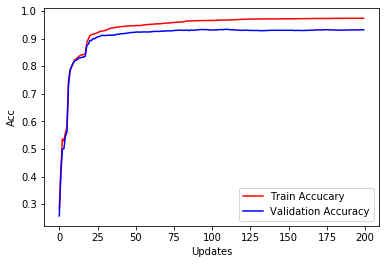

In [19]:
# setting hyperparameters and gettings epoch sizes
batch_size = 300
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)


for epoch in range(num_epochs):
    cur_loss = 0
    model.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = model(x_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    model.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = model(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = model(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(y_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')    

In [39]:
torch.save(model.state_dict(), "models/small_model")

# SAVE MODEL

# LR Scheduler

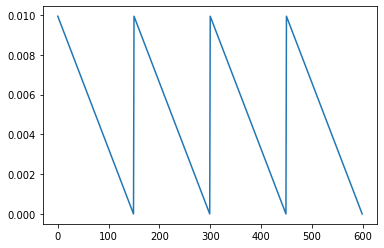

In [77]:


temp_model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(temp_model.parameters(), lr=a1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_a)


lrs = []

for i in range(n):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
#     print("Factor = ", round(0.65 ** i,3)," , Learning Rate = ",round(optimizer.param_groups[0]["lr"],3))
    scheduler.step()

plt.plot(range(n),lrs)

# SWA Training

In [ ]:
model = Net()
model.load_state_dict(torch.load("models/small_model"))
model.train()


#SWA VARIABLES
batch_size = 100
num_epochs_per_cycle = 5
num_cycles = 4



a1 = 0.5
a2 = 0.0001


num_bat = x_train.shape[0] // batch_size

c = num_epochs_per_cycle*num_bat
n = c*num_cycles

_t = lambda i: (1/c)*(((i)%c)+1)

_a = lambda i: (1-_t(i))*a1 + _t(i)*a2







# setting hyperparameters and gettings epoch sizes
batch_size = batch_size
num_epochs = num_epochs_per_cycle*num_cycles
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

lrs = []


#SWA OPTIMIZERS
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=a1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_a)


#SWA model params
#Spørg Niki
w_swa = [p.data.clone() for p in model.parameters() if p.requires_grad]




n_counter = 1
for epoch in range(num_epochs):
    cur_loss = 0
    model.train()
    for i in range(num_batches_train):
        lrs.append(optimizer.param_groups[0]["lr"])
        
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = model(x_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        
        cur_loss += batch_loss  
        
        ##############################################
        ################# $$ SWA $$ ##################
        ##############################################
        if n_counter % c == 0:
            n_models = n_counter/c
        
            ct = 0
            for p in model.parameters():
                if p.requires_grad:
                    w_swa[ct] = (w_swa[ct]*n_models + p.data) / (n_models+1)
                    ct+=1
        
        ##############################################   
        n_counter+=1
        
        
        
    losses.append(cur_loss / batch_size)

    model.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = model(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = model(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(y_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 5 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')  


/Users/Morten/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  1 : Train Loss 0.506026 , Train acc 0.799333, Valid acc 0.771333
Epoch  6 : Train Loss 0.459506 , Train acc 0.957333, Valid acc 0.925333
